In [326]:
import pandas as pd

In [327]:
df = pd.read_csv("../03-classification/bank-full.csv", sep=";")

base = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 
        'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[base]

df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [328]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [329]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [330]:
numerical = list(df.dtypes[df.dtypes == 'int64'].index)
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical.remove('y')
numerical, categorical

(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'],
 ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome'])

# Target Encoding

In [331]:
df['y'] = (df['y'] == 'yes').astype(int)
df['y'].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

# Split the Data

In [332]:
from sklearn.model_selection import train_test_split

In [333]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=len(df_test), random_state=1)

len(df_train), len(df_val), len(df_test)

(27125, 9043, 9043)

In [334]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['y'].values
y_val = df_val['y'].values
y_test = df_test['y'].values

del df_train['y']
del df_val['y']
del df_test['y']

# Question 1 
# ROC AUC Feature Importance

In [335]:
from sklearn.metrics import roc_auc_score

In [336]:
columns = ['balance', 'day', 'duration', 'previous']

for column in columns:
    auc = roc_auc_score(y_train, df_train[column])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[column])
    print(column, round(auc, 2))

balance 0.59
day 0.53
duration 0.81
previous 0.6


# Question 2
# One-Hot Encoding

In [337]:
from sklearn.feature_extraction import DictVectorizer

In [338]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Training the model

In [339]:
from sklearn.linear_model import LogisticRegression

In [340]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)

print(round(auc, 3))

0.9


# Question 3
# Precision and Recall

In [341]:
import numpy as np

In [342]:
threshold = np.linspace(0, 1, 101)
df_scores = pd.DataFrame(columns=['threshold', 'tp', 'tn', 'fp', 'fn'])

for t in threshold:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    df_scores.loc[len(df_scores)] = [t, tp, tn, fp, fn]
    
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [343]:
df_scores[::10]

,threshold,tp,tn,fp,fn,p,r
0,0.0,1098.0,0.0,7945.0,0.0,0.121420,1.000000
10,0.1,929.0,6452.0,1493.0,169.0,0.383567,0.846084
20,0.2,711.0,7250.0,695.0,387.0,0.505690,0.647541
30,0.3,567.0,7536.0,409.0,531.0,0.580943,0.516393
40,0.4,458.0,7675.0,270.0,640.0,0.629121,0.417122
50,0.5,370.0,7755.0,190.0,728.0,0.660714,0.336976
60,0.6,287.0,7812.0,133.0,811.0,0.683333,0.261384
70,0.7,222.0,7844.0,101.0,876.0,0.687307,0.202186
80,0.8,141.0,7877.0,68.0,957.0,0.674641,0.128415
90,0.9,76.0,7916.0,29.0,1022.0,0.723810,0.069217


# Interception point Precision X Recall

In [344]:
idx = np.argwhere(
        np.diff(
            np.sign(np.array(df_scores["p"]) - np.array(df_scores["r"]))
        )
    ).flatten()
    
df_scores.iloc[idx]

,threshold,tp,tn,fp,fn,p,r
26,0.26,620.0,7448.0,497.0,478.0,0.555058,0.564663
99,0.99,11.0,7940.0,5.0,1087.0,0.687500,0.010018


In [345]:
import matplotlib.pyplot as plt

%matplotlib inline

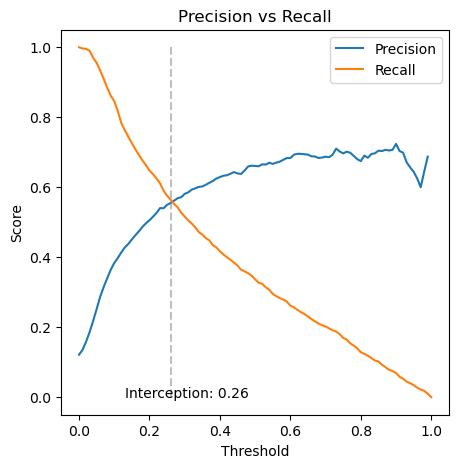

In [346]:
plt.figure(figsize= (5, 5))

plt.plot(df_scores.threshold, df_scores.p, label='Precision')
plt.plot(df_scores.threshold, df_scores.r, label='Recall')

plt.vlines(df_scores.threshold.iloc[idx[0]], 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.annotate(f'Interception: {df_scores.threshold.iloc[idx[0]]}', 
             xy=(df_scores.threshold.iloc[idx[0]], df_scores.p.iloc[idx[0]]), 
             xytext=(df_scores.threshold.iloc[idx[0]]/2, 0))

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall')

plt.legend()
plt.show()

# Question 4
# F1 Score

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

In [347]:
df_scores['f1'] = 2 * (df_scores.p * df_scores.r) / (df_scores.p + df_scores.r)
df_scores.sort_values(by='f1', ascending=False)

,threshold,tp,tn,fp,fn,p,r,f1
23,0.23,671.0,7374.0,571.0,427.0,0.540258,0.611111,0.573504
22,0.22,686.0,7328.0,617.0,412.0,0.526477,0.624772,0.571429
21,0.21,700.0,7288.0,657.0,398.0,0.515844,0.637523,0.570265
19,0.19,728.0,7208.0,737.0,370.0,0.496928,0.663024,0.568084
20,0.20,711.0,7250.0,695.0,387.0,0.505690,0.647541,0.567891
...,...,...,...,...,...,...,...,...
96,0.96,30.0,7927.0,18.0,1068.0,0.625000,0.027322,0.052356
97,0.97,24.0,7929.0,16.0,1074.0,0.600000,0.021858,0.042179
98,0.98,20.0,7934.0,11.0,1078.0,0.645161,0.018215,0.035430
99,0.99,11.0,7940.0,5.0,1087.0,0.687500,0.010018,0.019749


# Question 5
# K Fold

In [348]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [349]:
from sklearn.model_selection import KFold

In [350]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


# Question 6
# Hyperparameter Tuning

In [351]:
for C in [0.000001, 0.001, 1]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006
